# Important Modules

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats.mstats import winsorize
import scipy.stats as stats


In [2]:

# Define the directory where raw CSV files are stored
raw_folder_path = '/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/raw/Raw data ESG data 2025Feb'  # Update this if needed

# Define the directory where processed files should be saved
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# Ensure the processed folder exists
os.makedirs(processed_folder_path, exist_ok=True)

# List of ESG raw data files
csv_files = [
    "esg_raw_data_on_corporations_myu_5.csv",
    "esg_raw_data_on_corporations_myu_2.csv",
    "esg_raw_data_on_corporations_1.csv",
    "esg_raw_data_on_corporations_myu_4.csv",
    "esg_raw_data_on_corporations_myu_3.csv",
    "esg_raw_data_on_corporations_7.csv",
    "esg_raw_data_on_corporations_6.csv"
]

# Initialize empty lists for E, S, and G dataframes
e_dataframes = []
s_dataframes = []
g_dataframes = []

# Loop through each file and read the data
for filename in csv_files:
    file_path = os.path.join(raw_folder_path, filename)

    try:
        # Read CSV file with correct delimiter
        df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

        # Ensure 'pillar' column exists before filtering
        if 'pillar' in df.columns:
            e_dataframes.append(df[df['pillar'] == 'E'])
            s_dataframes.append(df[df['pillar'] == 'S'])
            g_dataframes.append(df[df['pillar'] == 'G'])

            print(f"Processed {filename}: E({len(e_dataframes[-1])}), S({len(s_dataframes[-1])}), G({len(g_dataframes[-1])})")
        else:
            print(f"Skipping {filename} - 'pillar' column missing.")

    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Combine all files into one per category
df_e = pd.concat(e_dataframes, ignore_index=True)
df_s = pd.concat(s_dataframes, ignore_index=True)
df_g = pd.concat(g_dataframes, ignore_index=True)

# Save the new CSV files in the processed directory
df_e.to_csv(os.path.join(processed_folder_path, "esg_environmental_data.csv"), index=False, sep='|')
df_s.to_csv(os.path.join(processed_folder_path, "esg_social_data.csv"), index=False, sep='|')
df_g.to_csv(os.path.join(processed_folder_path, "esg_governance_data.csv"), index=False, sep='|')

print("CSV files saved successfully in the processed folder:")
print(f"- Environmental Data: {len(df_e)} rows")
print(f"- Social Data: {len(df_s)} rows")
print(f"- Governance Data: {len(df_g)} rows")


Processed esg_raw_data_on_corporations_myu_5.csv: E(396333), S(51959), G(74546)
Processed esg_raw_data_on_corporations_myu_2.csv: E(894601), S(196542), G(231277)
Processed esg_raw_data_on_corporations_1.csv: E(1269834), S(768008), G(726410)
Processed esg_raw_data_on_corporations_myu_4.csv: E(624877), S(74975), G(112890)
Processed esg_raw_data_on_corporations_myu_3.csv: E(767791), S(100980), G(155926)
Processed esg_raw_data_on_corporations_7.csv: E(50502), S(14844), G(21025)
Processed esg_raw_data_on_corporations_6.csv: E(190863), S(25985), G(40755)
CSV files saved successfully in the processed folder:
- Environmental Data: 4194801 rows
- Social Data: 1233293 rows
- Governance Data: 1362829 rows


In [3]:

# Define file paths
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"
metric_summary_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/raw/metric_summary.csv"
industry_file_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/raw/industry.csv"  # Using the updated industry.csv file

# Load the Metric Summary file
metric_summary = pd.read_csv(metric_summary_path)

# Load the Industry file
industry_data = pd.read_csv(industry_file_path)

# Ensure 'perm_id' and 'Industry' columns exist
if 'perm_id' not in industry_data.columns or 'Industry' not in industry_data.columns or 'Company Name' not in industry_data.columns:
    raise ValueError("Industry file must contain 'perm_id', 'Industry', and 'Company Name' columns.")

# Load processed ESG files
e_file = os.path.join(processed_folder_path, "esg_environmental_data.csv")
s_file = os.path.join(processed_folder_path, "esg_social_data.csv")
g_file = os.path.join(processed_folder_path, "esg_governance_data.csv")

df_e = pd.read_csv(e_file, delimiter='|', encoding='utf-8')
df_s = pd.read_csv(s_file, delimiter='|', encoding='utf-8')
df_g = pd.read_csv(g_file, delimiter='|', encoding='utf-8')

# Merge industry data into ESG datasets using 'perm_id' first
df_e = df_e.merge(industry_data[['perm_id', 'Industry']], on='perm_id', how='left')
df_s = df_s.merge(industry_data[['perm_id', 'Industry']], on='perm_id', how='left')
df_g = df_g.merge(industry_data[['perm_id', 'Industry']], on='perm_id', how='left')

# If 'Industry' is missing, try matching with 'Company Name'
df_e = df_e.merge(industry_data[['Company Name', 'Industry']], left_on='company_name', right_on='Company Name', how='left', suffixes=('_perm', '_name'))
df_s = df_s.merge(industry_data[['Company Name', 'Industry']], left_on='company_name', right_on='Company Name', how='left', suffixes=('_perm', '_name'))
df_g = df_g.merge(industry_data[['Company Name', 'Industry']], left_on='company_name', right_on='Company Name', how='left', suffixes=('_perm', '_name'))

# Fill missing values: Use 'Industry_name' if 'Industry' is still NaN
df_e.loc[:, 'Industry'] = df_e['Industry_perm'].fillna(df_e['Industry_name'])
df_s.loc[:, 'Industry'] = df_s['Industry_perm'].fillna(df_s['Industry_name'])
df_g.loc[:, 'Industry'] = df_g['Industry_perm'].fillna(df_g['Industry_name'])

# Drop extra columns after merging
df_e.drop(columns=['Industry_perm', 'Industry_name', 'Company Name'], inplace=True, errors='ignore')
df_s.drop(columns=['Industry_perm', 'Industry_name', 'Company Name'], inplace=True, errors='ignore')
df_g.drop(columns=['Industry_perm', 'Industry_name', 'Company Name'], inplace=True, errors='ignore')

# Ensure no missing industries
df_e.loc[:, 'Industry'] = df_e['Industry'].fillna("Unknown")
df_s.loc[:, 'Industry'] = df_s['Industry'].fillna("Unknown")
df_g.loc[:, 'Industry'] = df_g['Industry'].fillna("Unknown")

# Split the datasets using the Metric Summary
e_risk_metrics = metric_summary[metric_summary['category'] == 'Environmental Risk']['metric_name'].tolist()
e_opportunity_metrics = metric_summary[metric_summary['category'] == 'Environmental Opportunity']['metric_name'].tolist()

df_e_risk = df_e[df_e['metric_name'].isin(e_risk_metrics)]
df_e_opportunity = df_e[df_e['metric_name'].isin(e_opportunity_metrics)]

s_risk_metrics = metric_summary[metric_summary['category'] == 'Social Risk']['metric_name'].tolist()
s_opportunity_metrics = metric_summary[metric_summary['category'] == 'Social Opportunity']['metric_name'].tolist()

df_s_risk = df_s[df_s['metric_name'].isin(s_risk_metrics)]
df_s_opportunity = df_s[df_s['metric_name'].isin(s_opportunity_metrics)]

g_risk_metrics = metric_summary[metric_summary['category'] == 'Governance Risk']['metric_name'].tolist()
g_opportunity_metrics = metric_summary[metric_summary['category'] == 'Governance Opportunity']['metric_name'].tolist()

df_g_risk = df_g[df_g['metric_name'].isin(g_risk_metrics)]
df_g_opportunity = df_g[df_g['metric_name'].isin(g_opportunity_metrics)]

# Save the final split files in the processed directory
df_e_risk.to_csv(os.path.join(processed_folder_path, "esg_environmental_risk.csv"), index=False, sep='|')
df_e_opportunity.to_csv(os.path.join(processed_folder_path, "esg_environmental_opportunity.csv"), index=False, sep='|')

df_s_risk.to_csv(os.path.join(processed_folder_path, "esg_social_risk.csv"), index=False, sep='|')
df_s_opportunity.to_csv(os.path.join(processed_folder_path, "esg_social_opportunity.csv"), index=False, sep='|')

df_g_risk.to_csv(os.path.join(processed_folder_path, "esg_governance_risk.csv"), index=False, sep='|')
df_g_opportunity.to_csv(os.path.join(processed_folder_path, "esg_governance_opportunity.csv"), index=False, sep='|')

# Verify missing industry values
missing_e = df_e['Industry'].isnull().sum()
missing_s = df_s['Industry'].isnull().sum()
missing_g = df_g['Industry'].isnull().sum()

print("🔍 Industry Data Final Verification:")
print(f"Environmental Dataset (E) - Missing Industries: {missing_e}")
print(f"Social Dataset (S) - Missing Industries: {missing_s}")
print(f"Governance Dataset (G) - Missing Industries: {missing_g}")

print("\n✅ All missing industry values have been filled. Files updated successfully.")


🔍 Industry Data Final Verification:
Environmental Dataset (E) - Missing Industries: 0
Social Dataset (S) - Missing Industries: 0
Governance Dataset (G) - Missing Industries: 0

✅ All missing industry values have been filled. Files updated successfully.


In [4]:
# Define file paths
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# List of files to clean
files_to_clean = [
    "esg_environmental_risk.csv",
    "esg_environmental_opportunity.csv",
    "esg_social_risk.csv",
    "esg_social_opportunity.csv",
    "esg_governance_risk.csv",
    "esg_governance_opportunity.csv"
]

# Columns to remove
columns_to_remove = ["metric_unit", "headquarter_country", "reported_date", "provider_name"]

# Process each file
for filename in files_to_clean:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    # Extract year from 'metric_year' column
    if 'metric_year' in df.columns:
        df['year'] = pd.to_datetime(df['metric_year'], errors='coerce').dt.year  # Extract year
        df.drop(columns=['metric_year'], inplace=True)  # Remove original column after extraction

    # Drop specified columns if they exist
    df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True, errors='ignore')

    # Drop columns that are completely empty (100% missing)
    df_cleaned = df.dropna(axis=1, how='all')

    # Save the cleaned file with `_cleaned` suffix
    cleaned_file_path = os.path.join(processed_folder_path, filename.replace('.csv', '_cleaned.csv'))
    df_cleaned.to_csv(cleaned_file_path, index=False, sep='|')

    print(f"✅ Cleaned file saved: {cleaned_file_path} (Rows: {len(df_cleaned)})")

print("\n🎯 Cleaning process complete! All cleaned files are now stored in the processed folder.")

✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_environmental_risk_cleaned.csv (Rows: 3203808)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_environmental_opportunity_cleaned.csv (Rows: 754598)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_social_risk_cleaned.csv (Rows: 740717)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_social_opportunity_cleaned.csv (Rows: 496681)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_governance_risk_cleaned.csv (Rows: 257996)
✅ Cleaned file saved: /Users/sujanbharadwaj/Library/Mobile Documents/com~appl

In [5]:
# Define file path
file_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed/esg_social_opportunity_cleaned.csv"

# Read the CSV file using the correct delimiter '|'
df_soc_oppr_cleaned = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

# Display the first few rows
print(df_soc_oppr_cleaned.head())

      company_name     perm_id data_type  disclosure  \
0  Landsbankinn hf  5000632996     float    REPORTED   
1  Landsbankinn hf  5000632996       int    REPORTED   
2  Landsbankinn hf  5000632996       int    REPORTED   
3  Landsbankinn hf  5000632996       int    REPORTED   
4  Landsbankinn hf  5000632996       int  CALCULATED   

                                  metric_description  \
0                     Percentage of women employees.   
1  Has the company established a program or an in...   
2  Has the company established a program or an in...   
3  Does the company have a provision or comply wi...   
4  Does the company claim to have an ISO 14000 or...   

                metric_name  metric_value  nb_points_of_observations pillar  \
0            WOMENEMPLOYEES         54.68                        293      S   
1  ANIMAL_TESTING_REDUCTION          0.00                        293      S   
2  ANIMAL_TESTING_REDUCTION          0.00                        293      S   
3  WHISTLE

In [6]:
# List of cleaned files
files_to_visualize = [
    "esg_environmental_risk_cleaned.csv",
    "esg_environmental_opportunity_cleaned.csv",
    "esg_social_risk_cleaned.csv",
    "esg_social_opportunity_cleaned.csv",
    "esg_governance_risk_cleaned.csv",
    "esg_governance_opportunity_cleaned.csv"
]

# Set visual style
sns.set_style("whitegrid")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


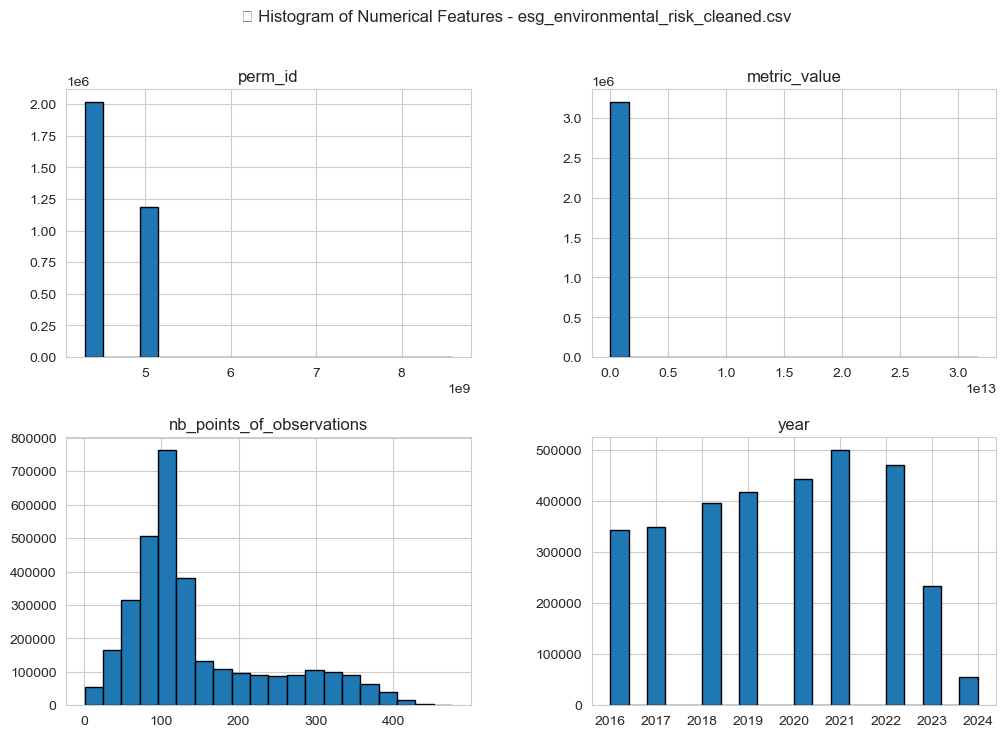


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


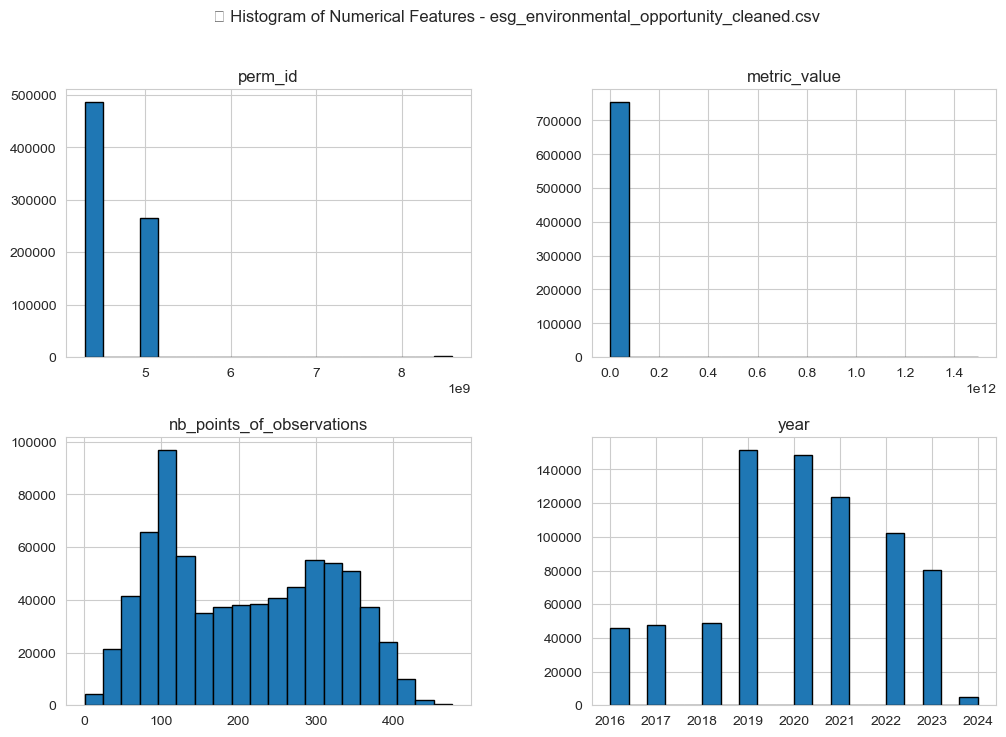


 Generating visualizations for: esg_social_risk_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


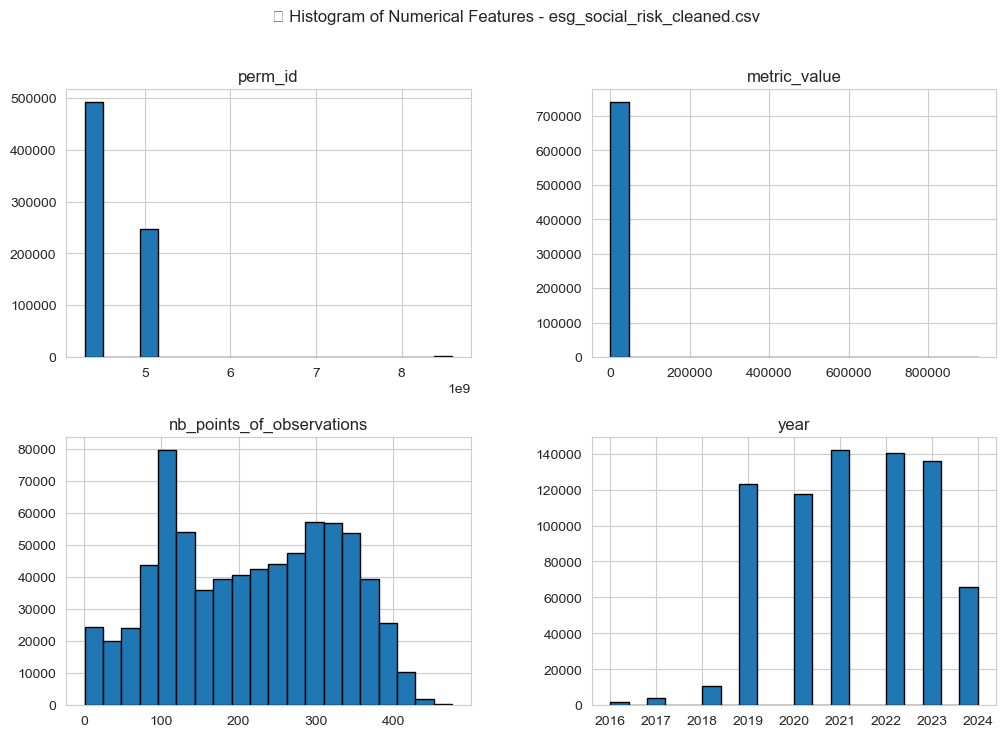


 Generating visualizations for: esg_social_opportunity_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


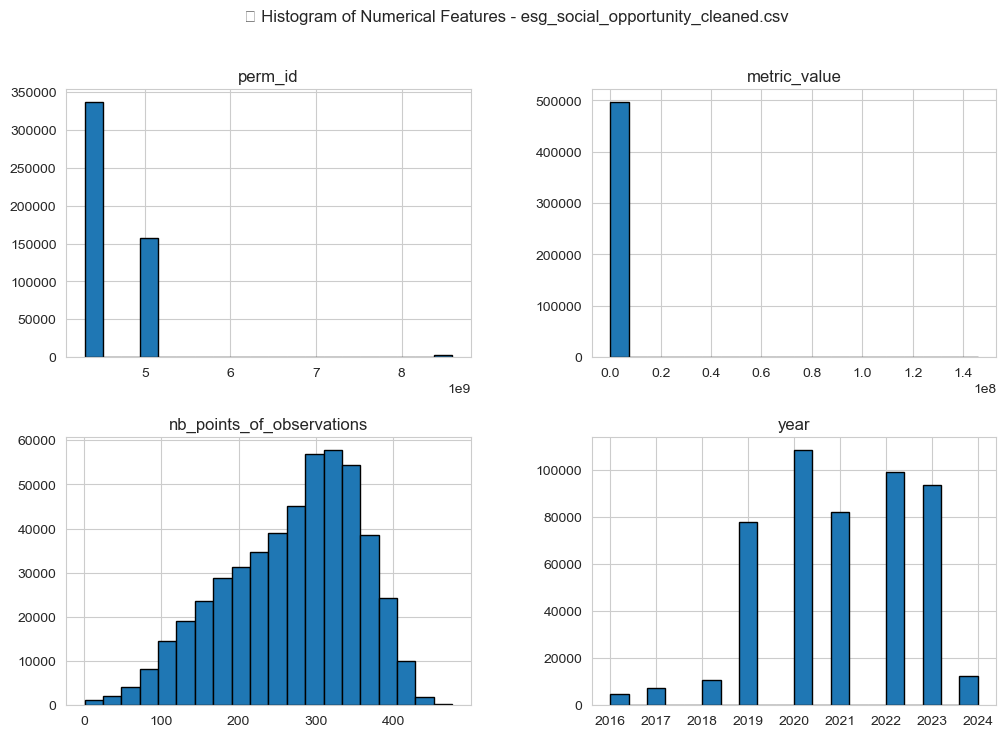


 Generating visualizations for: esg_governance_risk_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


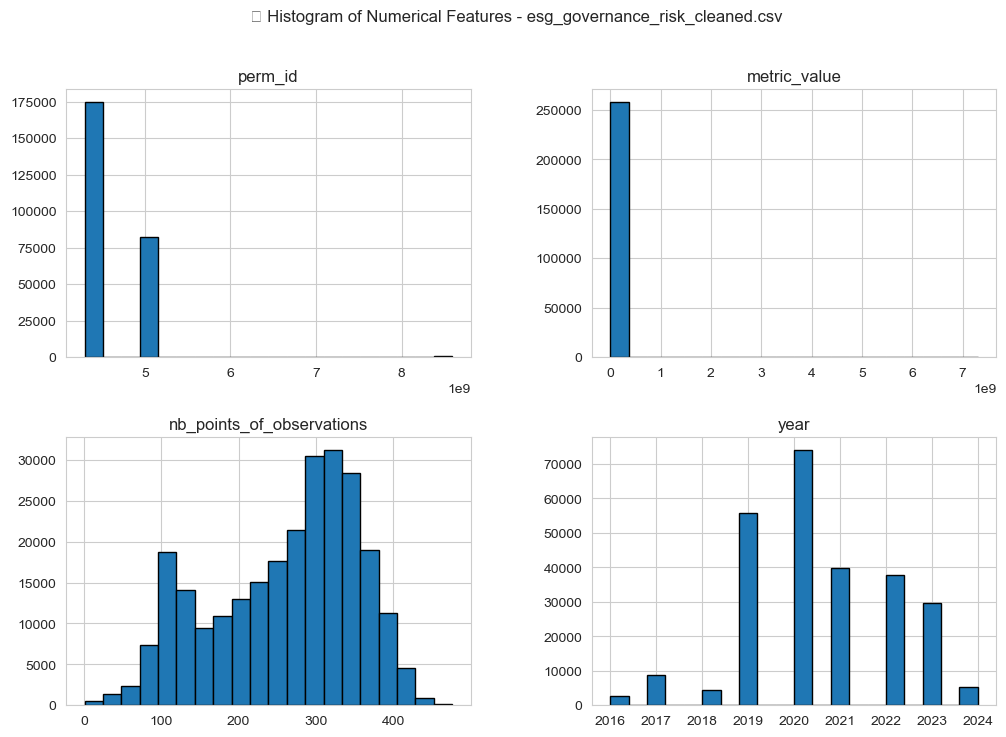


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


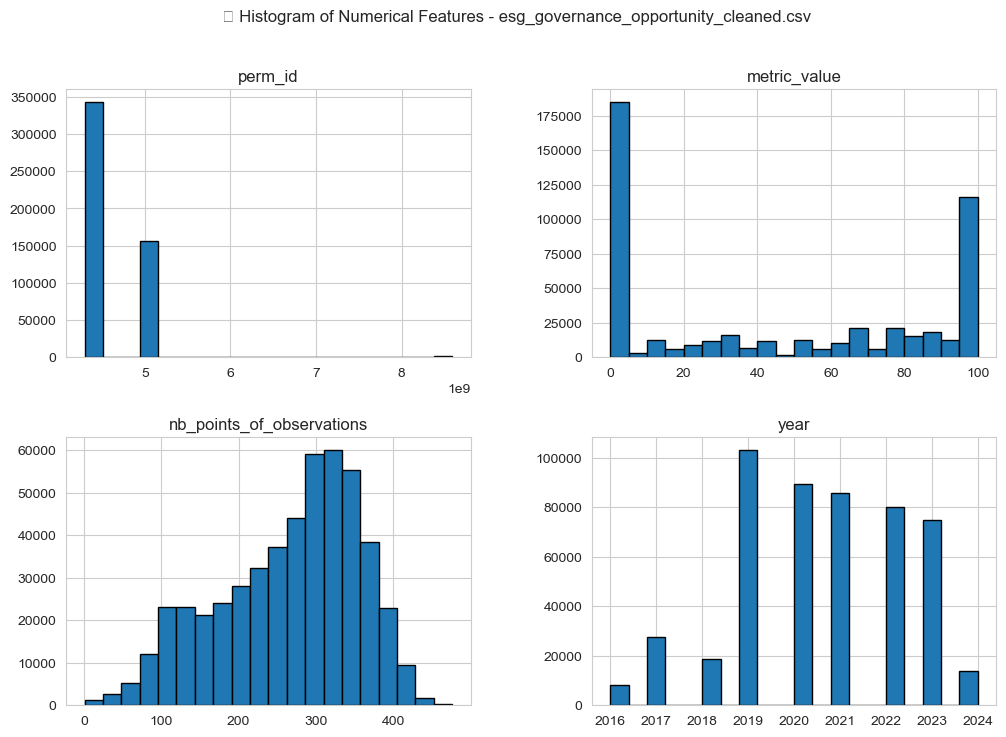


 Visualization process complete for all files!


In [7]:
# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    # Histogram for numerical columns
    if len(num_cols) > 0:
        df[num_cols].hist(figsize=(12, 8), bins=20, edgecolor='black')
        plt.suptitle(f"📈 Histogram of Numerical Features - {filename}")
        plt.show()

print("\n Visualization process complete for all files!")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


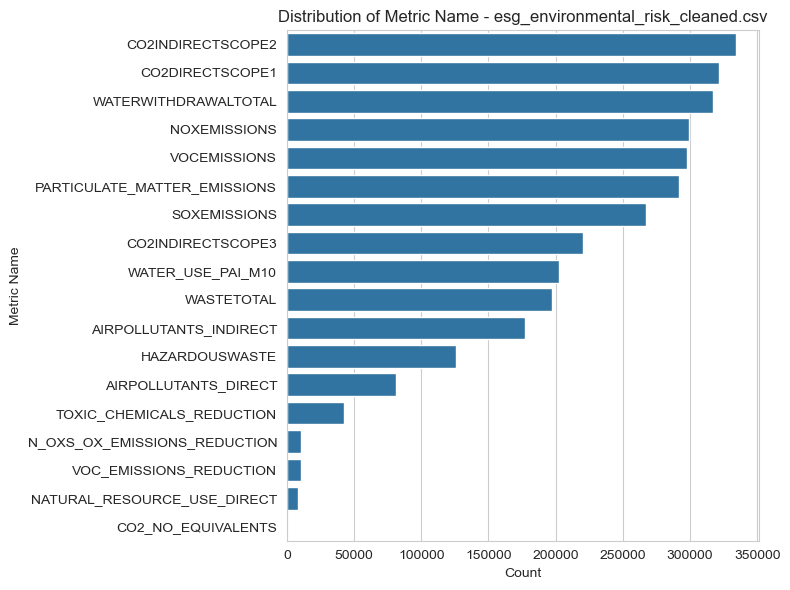


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


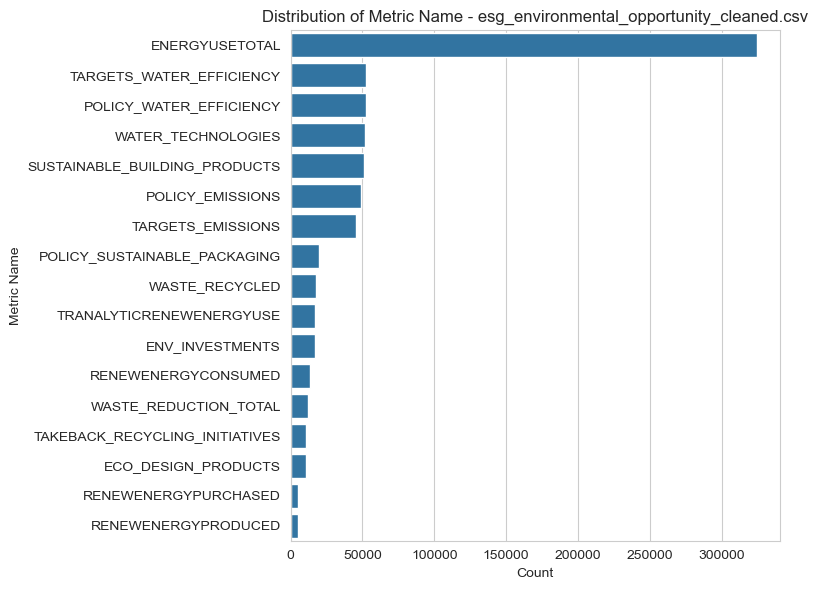


 Generating visualizations for: esg_social_risk_cleaned.csv


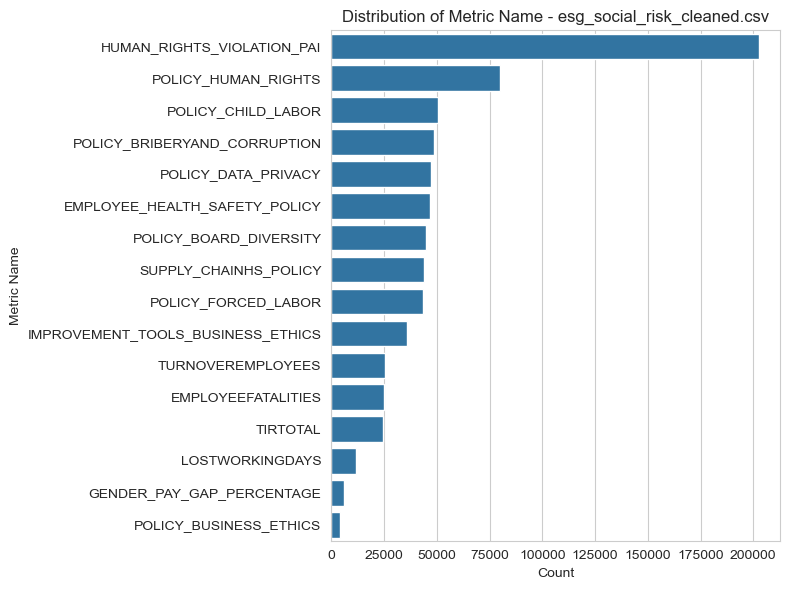


 Generating visualizations for: esg_social_opportunity_cleaned.csv


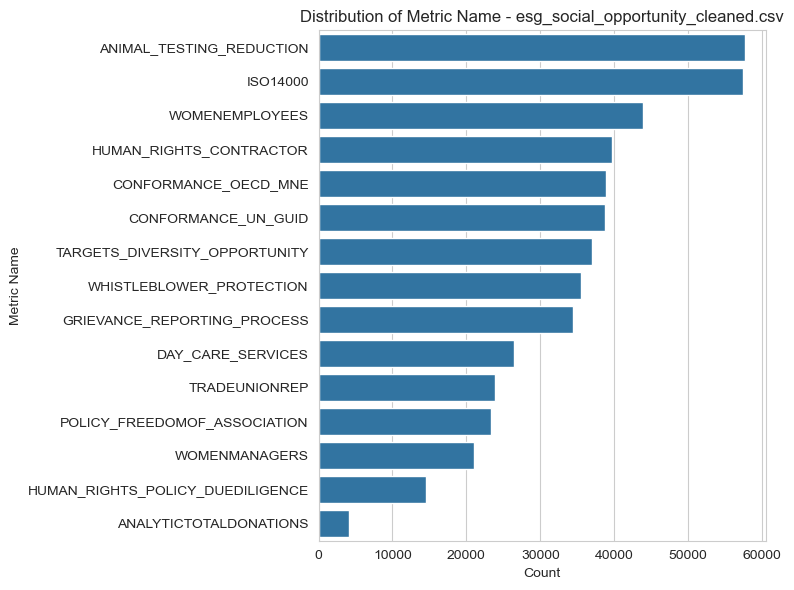


 Generating visualizations for: esg_governance_risk_cleaned.csv


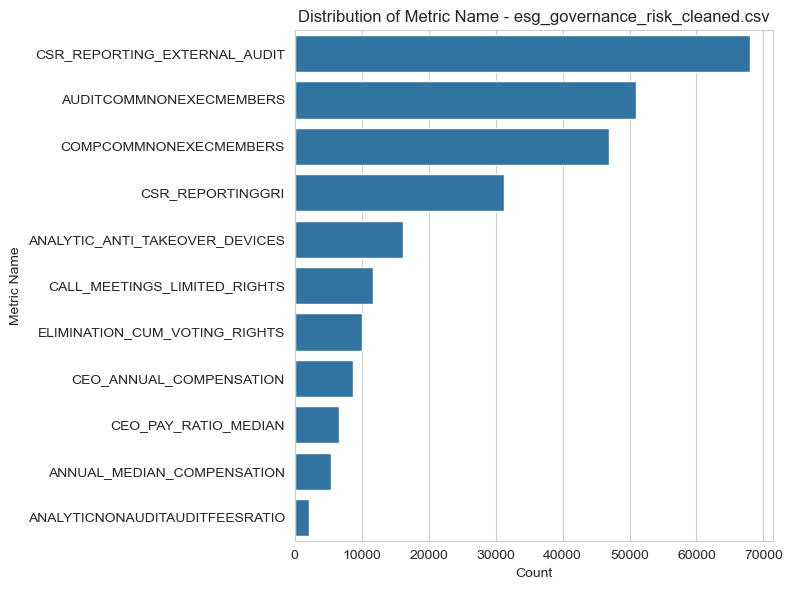


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


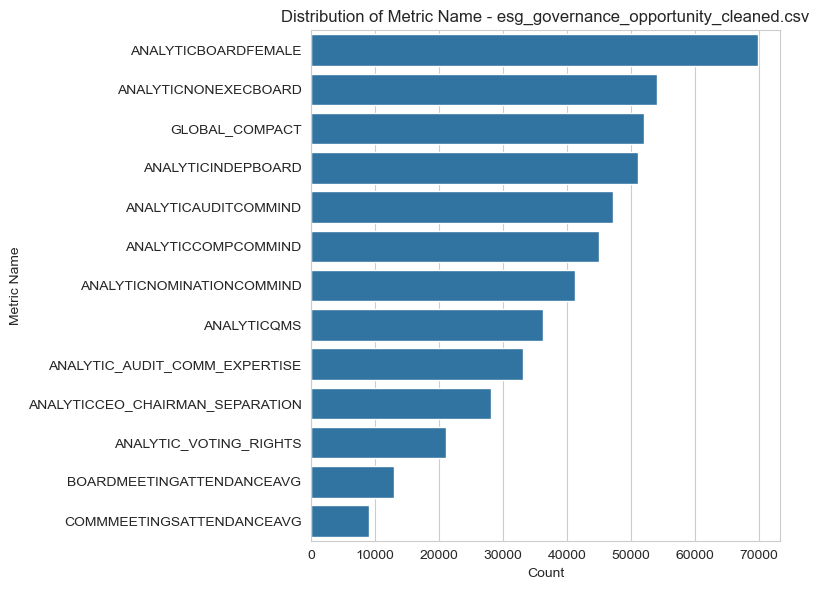


 Visualization process complete for all files!


In [8]:
	
target_column = "metric_name" 

# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Check if the target column exists
    if target_column in df.columns:
        plt.figure(figsize=(8, 6))

        # Display only the top 20 categories for better readability
        top_categories = df[target_column].value_counts().nlargest(20)

        sns.barplot(y=top_categories.index, x=top_categories.values, orient='h')

        plt.xlabel("Count")
        plt.ylabel(target_column.replace("_", " ").title())  # Format column name
        plt.title(f"Distribution of {target_column.replace('_', ' ').title()} - {filename}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{target_column}' column not found in {filename}")

print("\n Visualization process complete for all files!")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


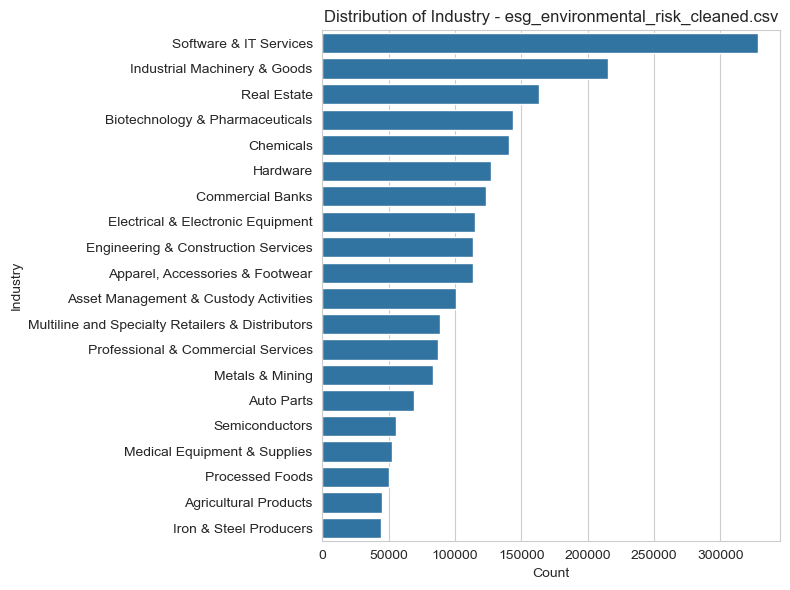


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


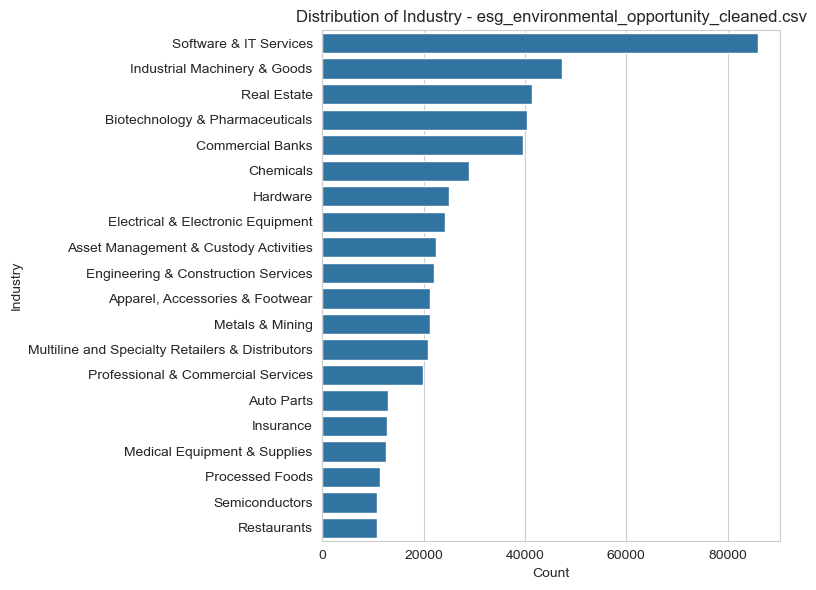


 Generating visualizations for: esg_social_risk_cleaned.csv


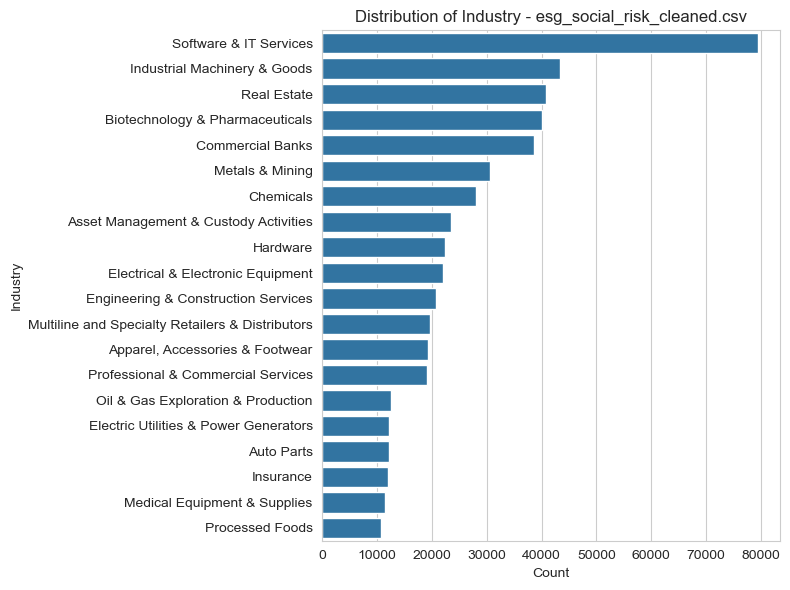


 Generating visualizations for: esg_social_opportunity_cleaned.csv


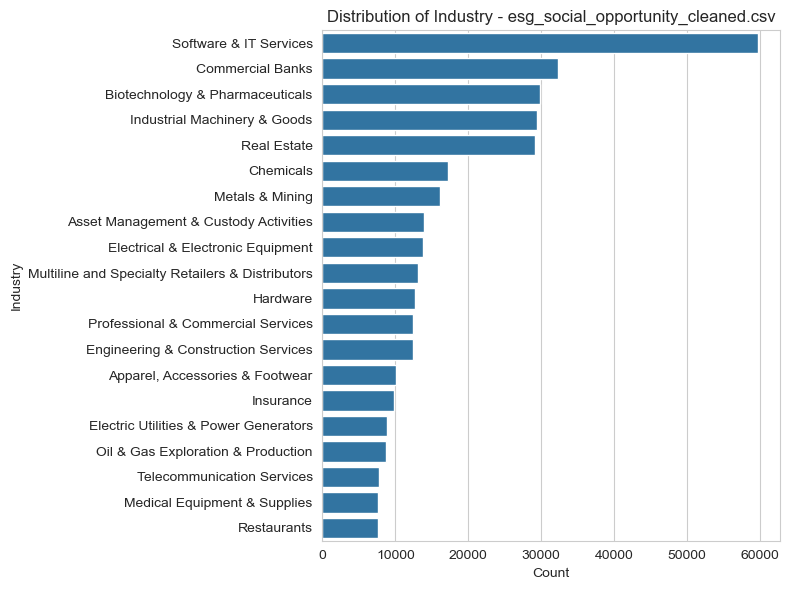


 Generating visualizations for: esg_governance_risk_cleaned.csv


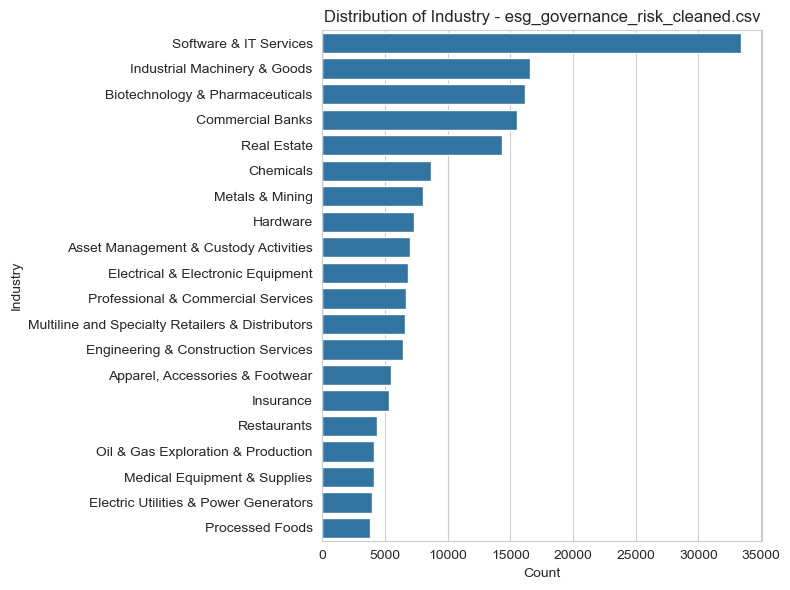


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


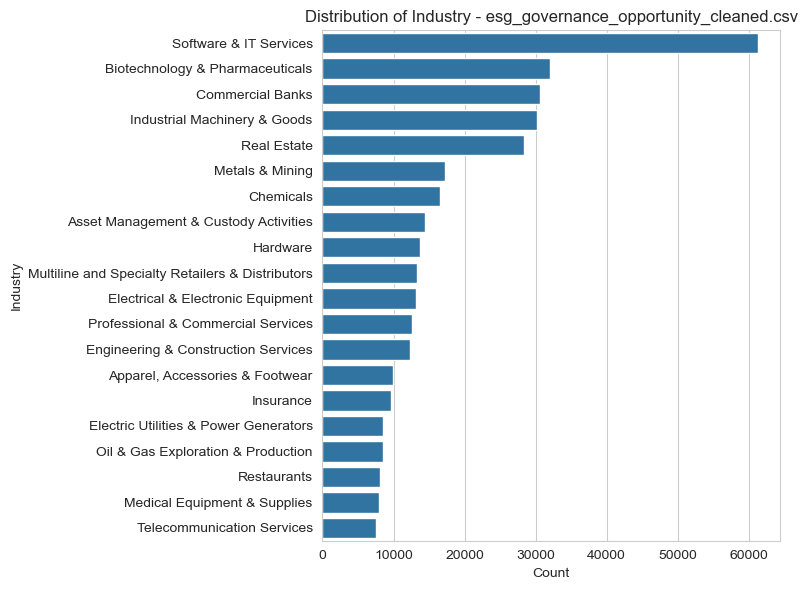


 Visualization process complete for all files!


In [9]:
target_column = "Industry" 

# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Check if the target column exists
    if target_column in df.columns:
        plt.figure(figsize=(8, 6))

        # Display only the top 20 categories for better readability
        top_categories = df[target_column].value_counts().nlargest(20)

        sns.barplot(y=top_categories.index, x=top_categories.values, orient='h')

        plt.xlabel("Count")
        plt.ylabel(target_column.replace("_", " ").title())  # Format column name
        plt.title(f"Distribution of {target_column.replace('_', ' ').title()} - {filename}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{target_column}' column not found in {filename}")

print("\n Visualization process complete for all files!")


 Generating visualizations for: esg_environmental_risk_cleaned.csv


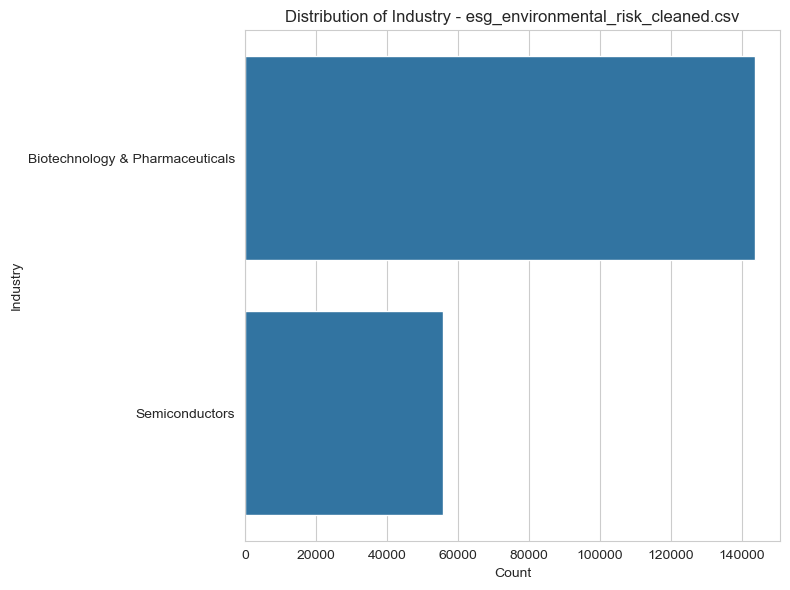


 Generating visualizations for: esg_environmental_opportunity_cleaned.csv


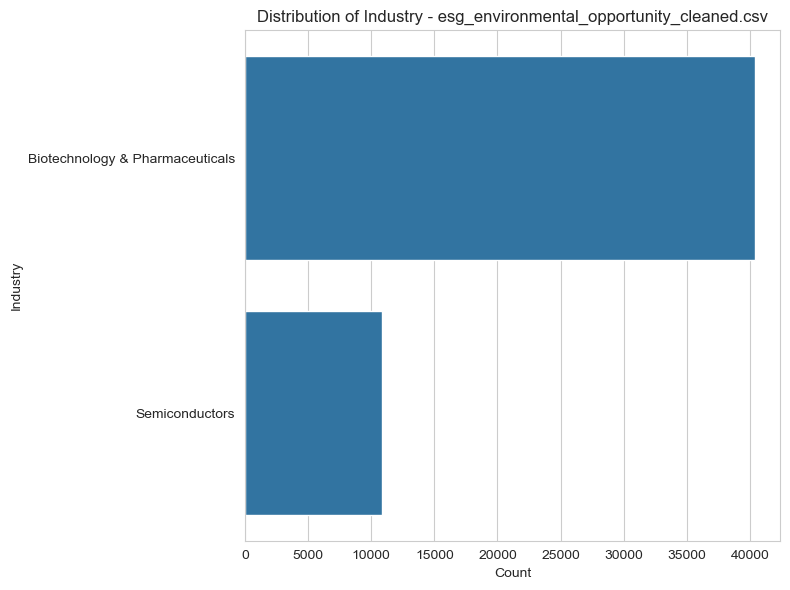


 Generating visualizations for: esg_social_risk_cleaned.csv


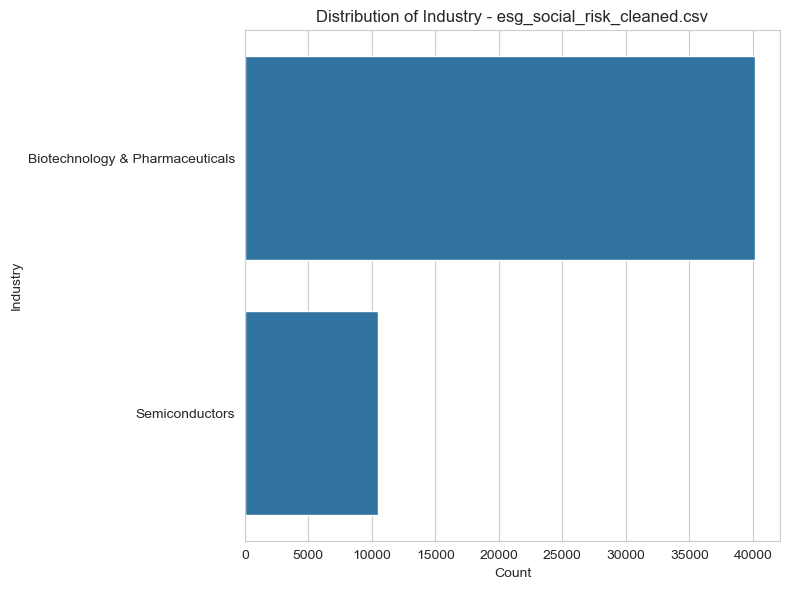


 Generating visualizations for: esg_social_opportunity_cleaned.csv


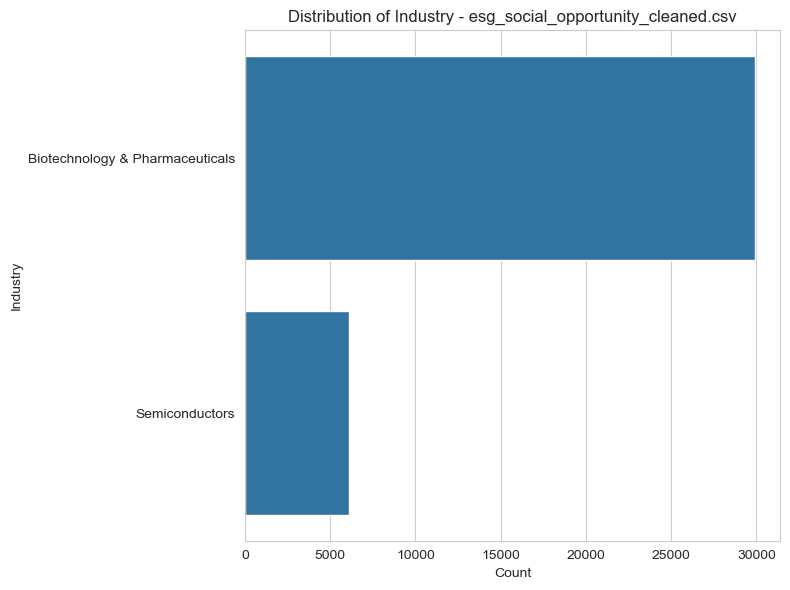


 Generating visualizations for: esg_governance_risk_cleaned.csv


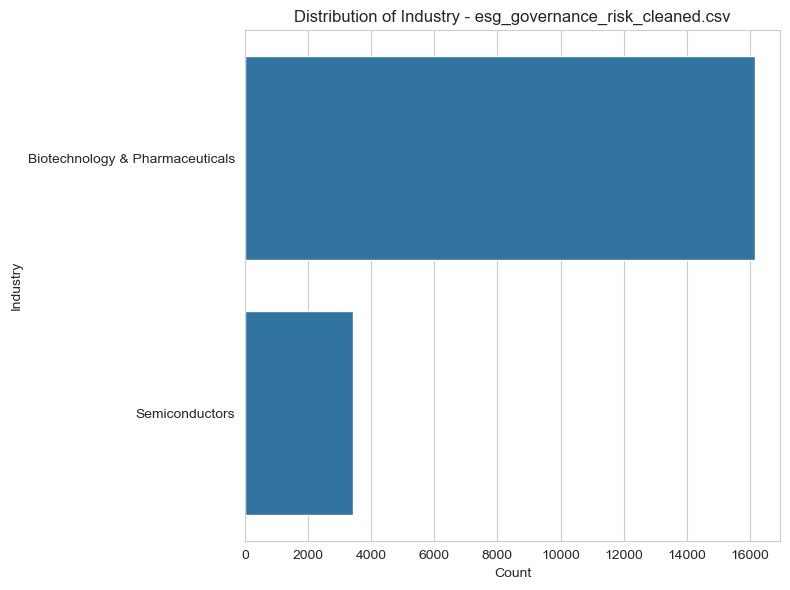


 Generating visualizations for: esg_governance_opportunity_cleaned.csv


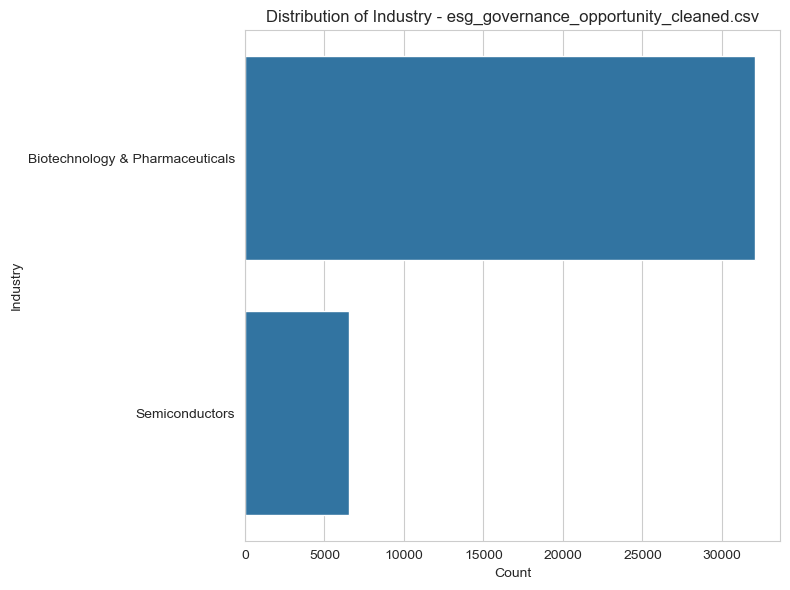


✅ Visualization process complete for selected industries in all files!


In [10]:
# Define the target column and industries to focus on
target_column = "Industry"
selected_industries = ["Semiconductors", "Biotechnology & Pharmaceuticals"]  # Change these to your desired industries

# Loop through each file and generate visualizations
for filename in files_to_visualize:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    print(f"\n Generating visualizations for: {filename}")

    # Check if the target column exists
    if target_column in df.columns:
        # Filter dataset for selected industries
        df_filtered = df[df[target_column].isin(selected_industries)]

        # Check if filtered data is empty
        if df_filtered.empty:
            print(f"⚠️ No data found for selected industries in {filename}")
            continue

        plt.figure(figsize=(8, 6))

        # Count the occurrences of selected industries
        industry_counts = df_filtered[target_column].value_counts()

        sns.barplot(y=industry_counts.index, x=industry_counts.values, orient='h')

        plt.xlabel("Count")
        plt.ylabel(target_column.replace("_", " ").title())  # Format column name
        plt.title(f"Distribution of {target_column.replace('_', ' ').title()} - {filename}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ '{target_column}' column not found in {filename}")

print("\n✅ Visualization process complete for selected industries in all files!")

In [ ]:

# Define file paths
processed_folder_path = "/Users/sujanbharadwaj/Library/Mobile Documents/com~apple~CloudDocs/Documents/Ontology_PCA_Project/data/processed"

# List of cleaned ESG files
files_to_filter = [
    "esg_environmental_risk_cleaned.csv",
    "esg_environmental_opportunity_cleaned.csv",
    "esg_social_risk_cleaned.csv",
    "esg_social_opportunity_cleaned.csv",
    "esg_governance_risk_cleaned.csv",
    "esg_governance_opportunity_cleaned.csv"
]

# Industries to focus on
selected_industries = ["Semiconductors", "Biotechnology & Pharmaceuticals"]

# Loop through each file, filter for industries, and save as a new file
for filename in files_to_filter:
    file_path = os.path.join(processed_folder_path, filename)

    # Load the dataset
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')

    # Filter for selected industries
    df_filtered = df[df["Industry"].isin(selected_industries)]

    # Define new filename
    new_filename = filename.replace(".csv", "_industry.csv")
    output_path = os.path.join(processed_folder_path, new_filename)

    # Save filtered dataset
    df_filtered.to_csv(output_path, index=False, sep='|')

    print(f"✅ Saved: {new_filename} with {df_filtered.shape[0]} rows")

print("\n🚀 Industry-specific ESG files have been successfully created!")


✅ Saved: esg_environmental_risk_cleaned_industry.csv with 199425 rows
✅ Saved: esg_environmental_opportunity_cleaned_industry.csv with 51207 rows
✅ Saved: esg_social_risk_cleaned_industry.csv with 50603 rows
✅ Saved: esg_social_opportunity_cleaned_industry.csv with 35987 rows
✅ Saved: esg_governance_risk_cleaned_industry.csv with 19569 rows
✅ Saved: esg_governance_opportunity_cleaned_industry.csv with 38592 rows

🚀 Industry-specific ESG files have been successfully created!


In [17]:
# List of industry-specific ESG files
industry_files = [
    "esg_environmental_risk_cleaned_industry.csv",
    "esg_environmental_opportunity_cleaned_industry.csv",
    "esg_social_risk_cleaned_industry.csv",
    "esg_social_opportunity_cleaned_industry.csv",
    "esg_governance_risk_cleaned_industry.csv",
    "esg_governance_opportunity_cleaned_industry.csv"
]

# Load data from all files into a dictionary
industry_data = {}
for filename in industry_files:
    file_path = os.path.join(processed_folder_path, filename)
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')
    industry_data[filename] = df
    print(f"✅ Loaded {filename}: {df.shape[0]} rows")
# Load data from all files into a dictionary
industry_data = {}
for filename in industry_files:
    file_path = os.path.join(processed_folder_path, filename)
    df = pd.read_csv(file_path, delimiter='|', encoding='utf-8')
    industry_data[filename] = df


✅ Loaded esg_environmental_risk_cleaned_industry.csv: 199425 rows
✅ Loaded esg_environmental_opportunity_cleaned_industry.csv: 51207 rows
✅ Loaded esg_social_risk_cleaned_industry.csv: 50603 rows
✅ Loaded esg_social_opportunity_cleaned_industry.csv: 35987 rows
✅ Loaded esg_governance_risk_cleaned_industry.csv: 19569 rows
✅ Loaded esg_governance_opportunity_cleaned_industry.csv: 38592 rows


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/3296218332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")


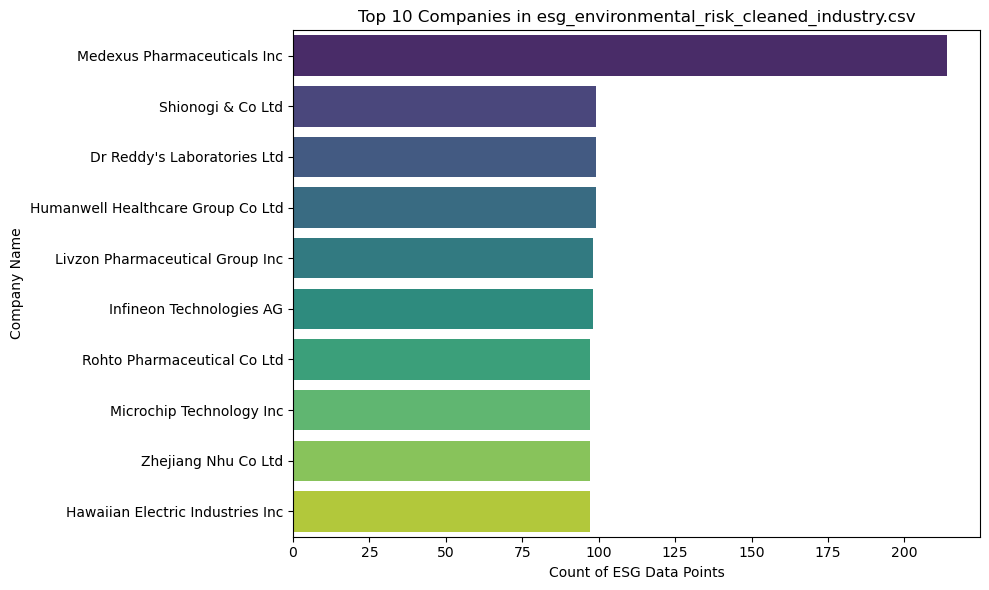

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/3296218332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")


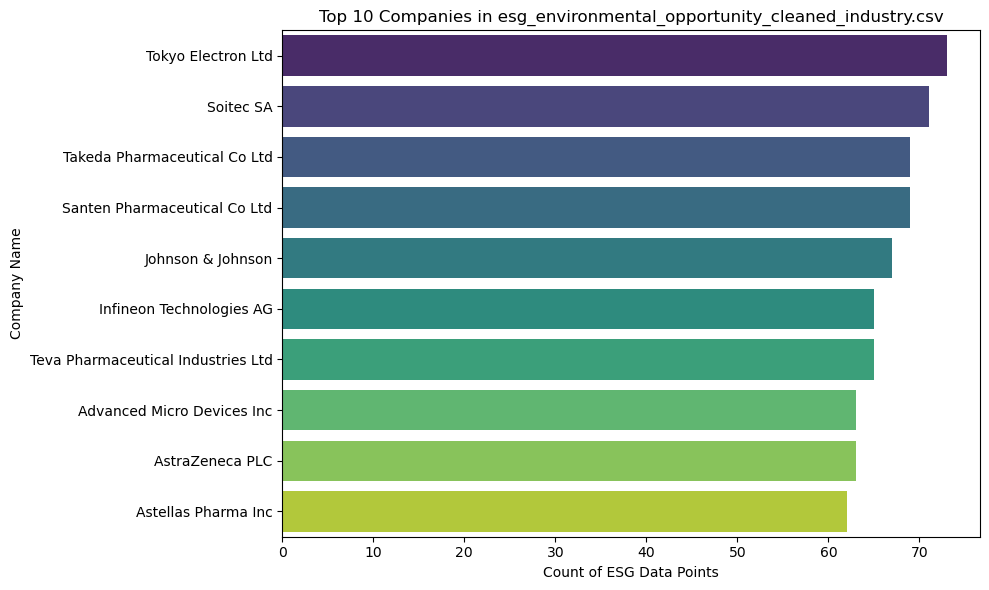

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/3296218332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")


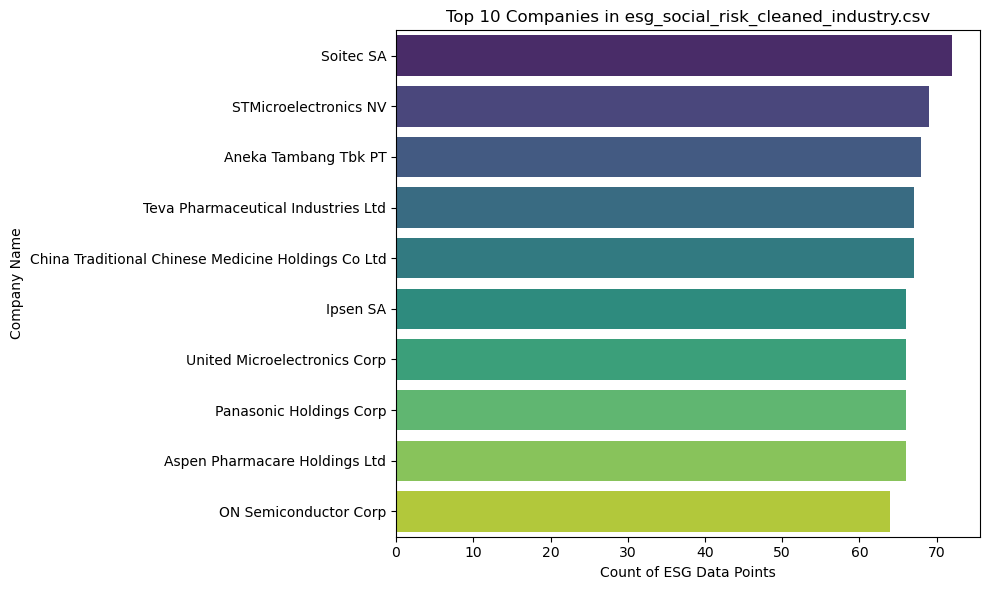

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/3296218332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")


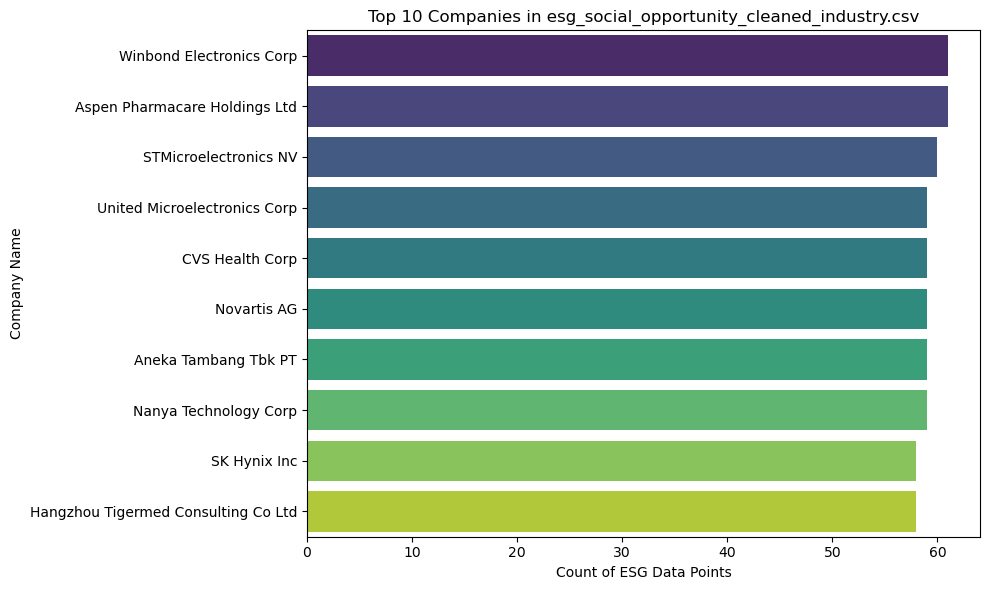

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/3296218332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")


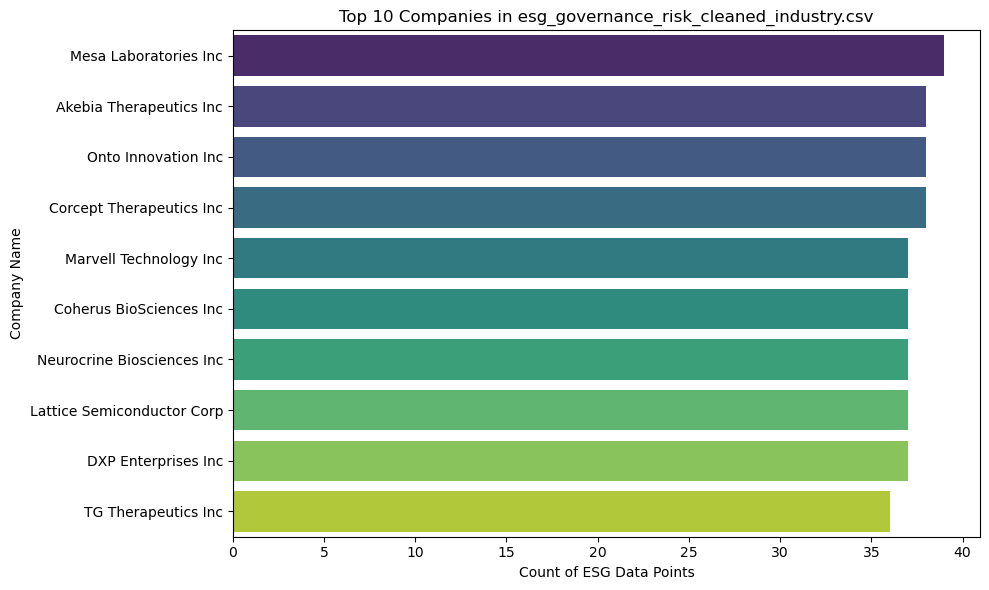

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/3296218332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")


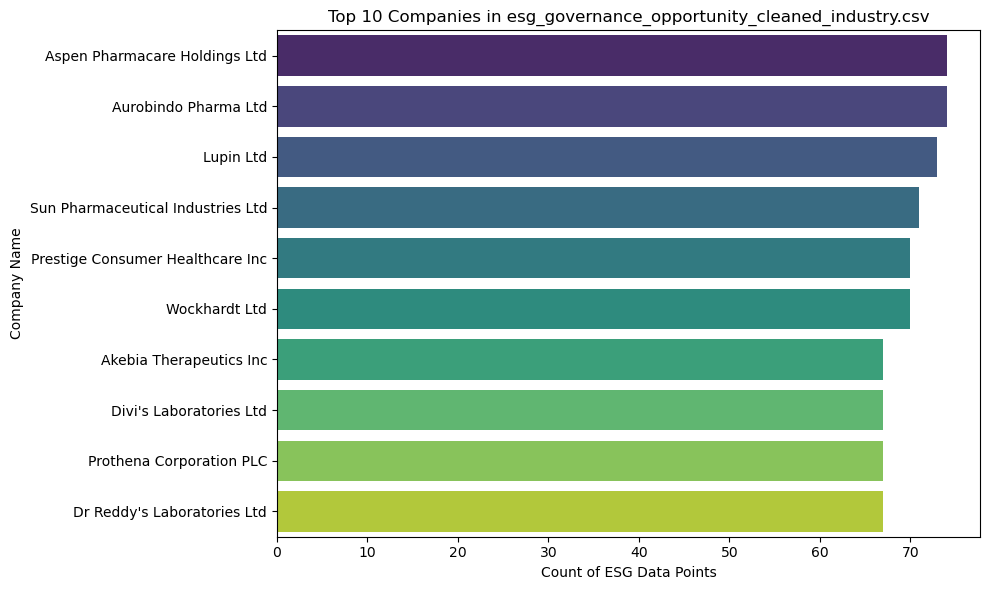

In [18]:
top_companies_data = {}

for filename, df in industry_data.items():
    top_companies = df["company_name"].value_counts().head(10)
    top_companies_data[filename] = top_companies

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_companies.index, x=top_companies.values, palette="viridis")
    plt.xlabel("Count of ESG Data Points")
    plt.ylabel("Company Name")
    plt.title(f"Top 10 Companies in {filename}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


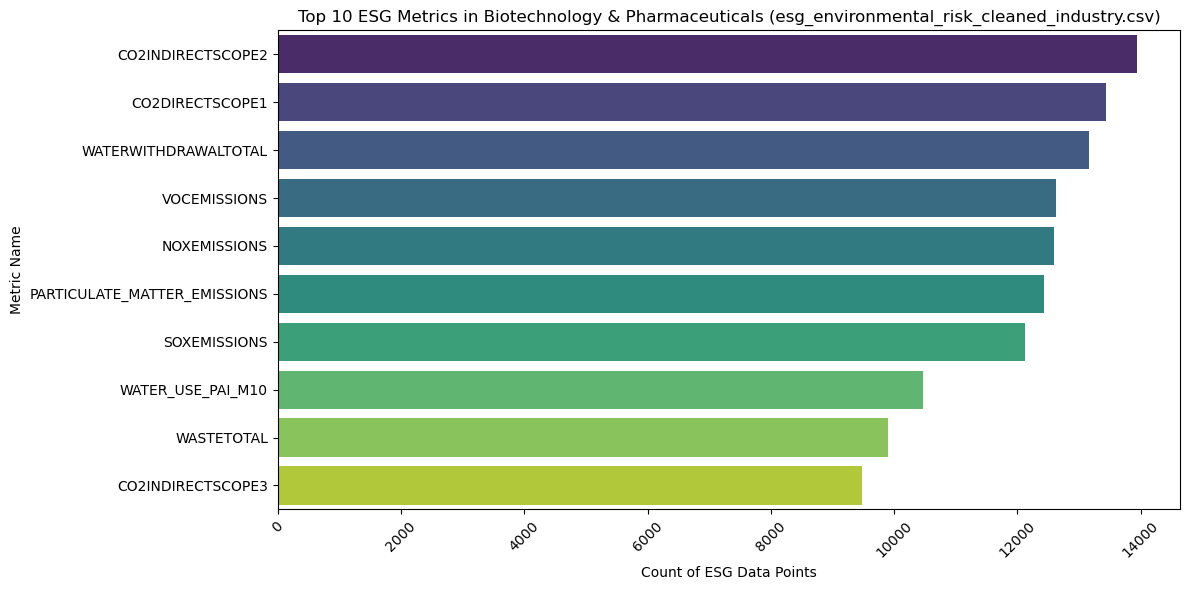

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


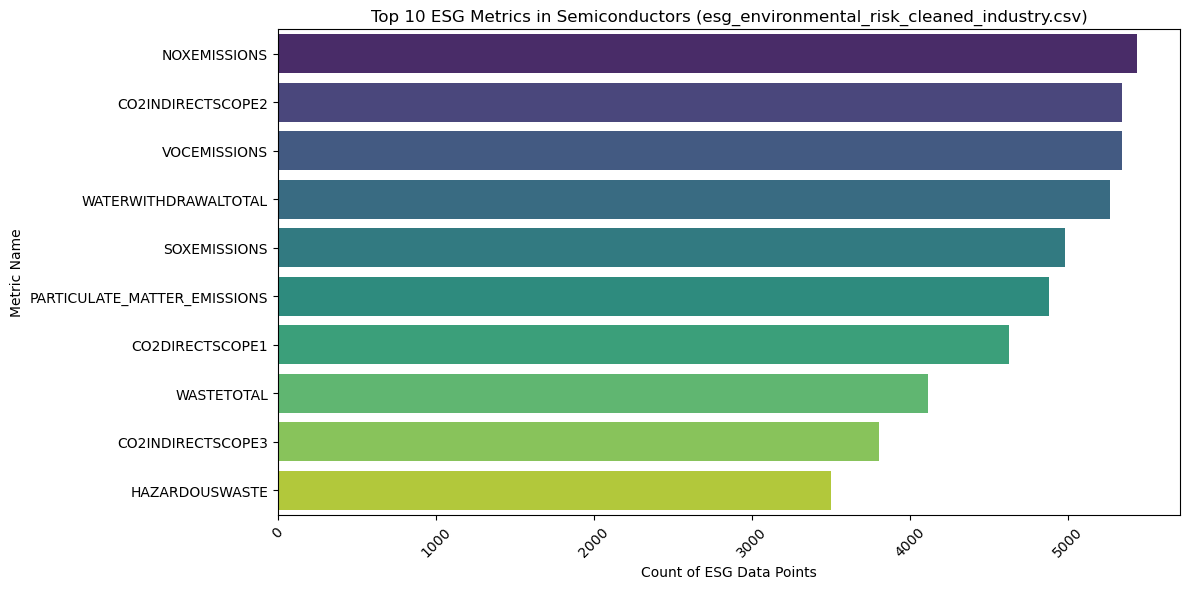

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


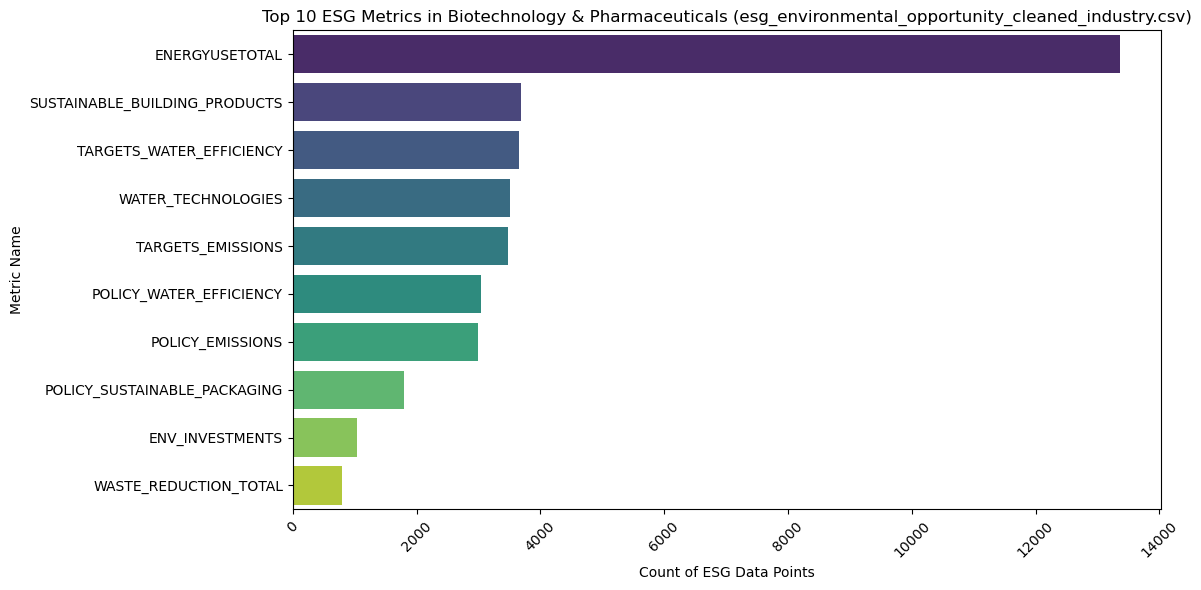

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


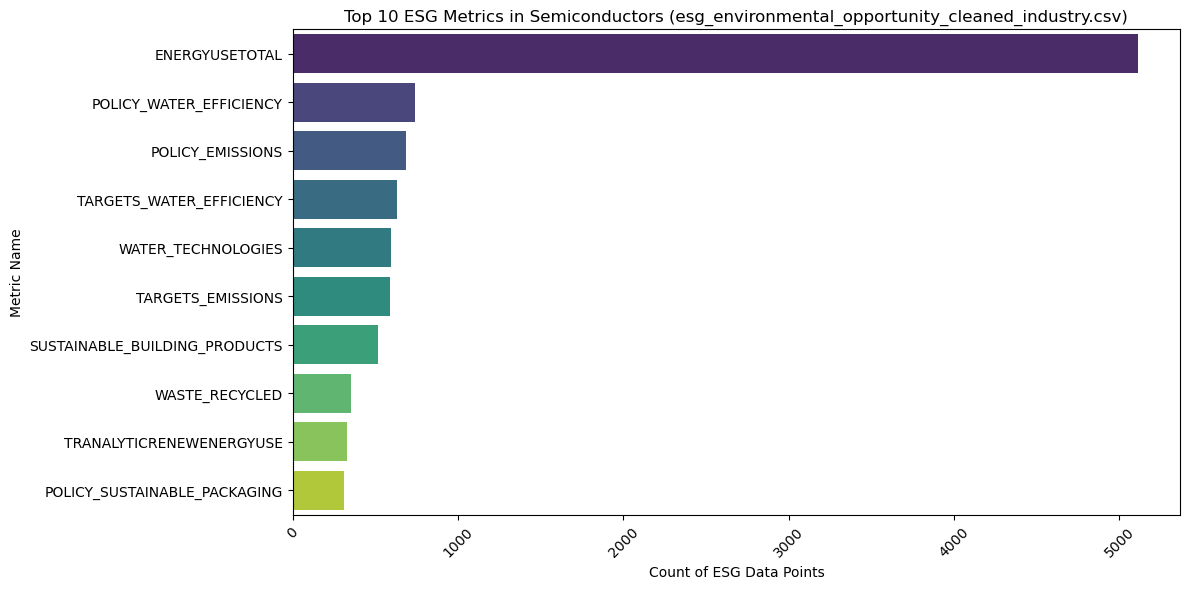

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


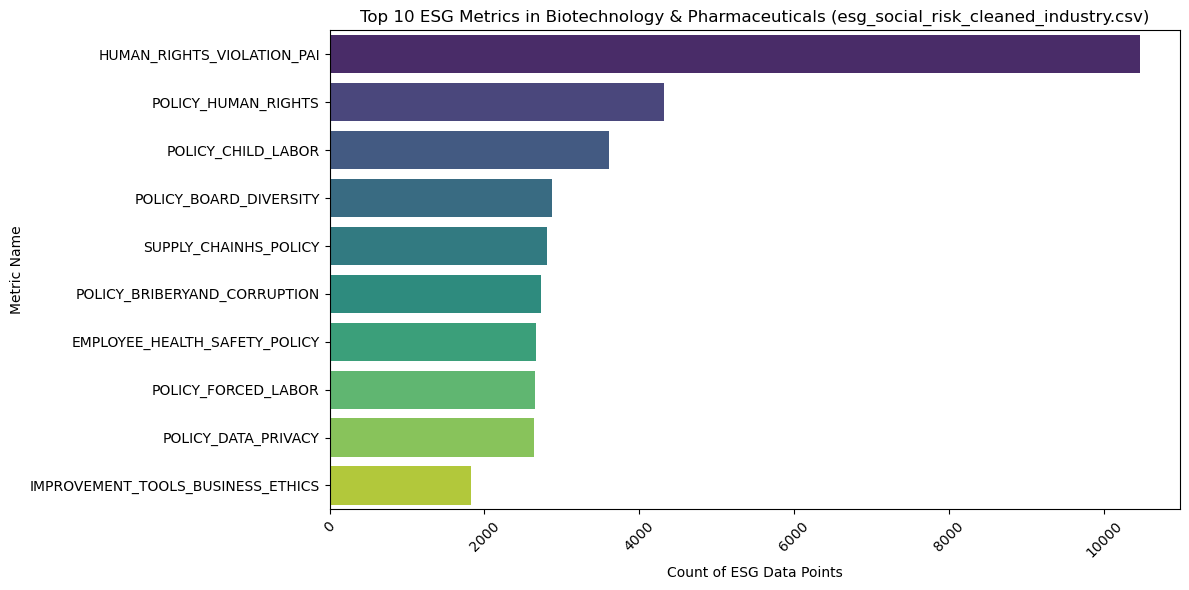

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


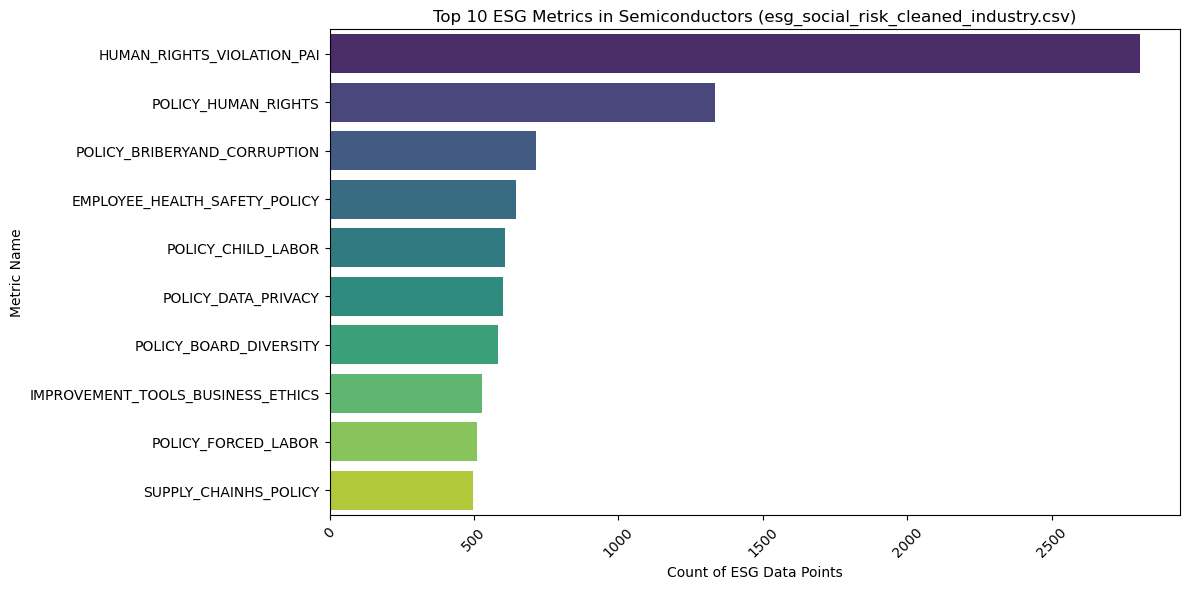

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


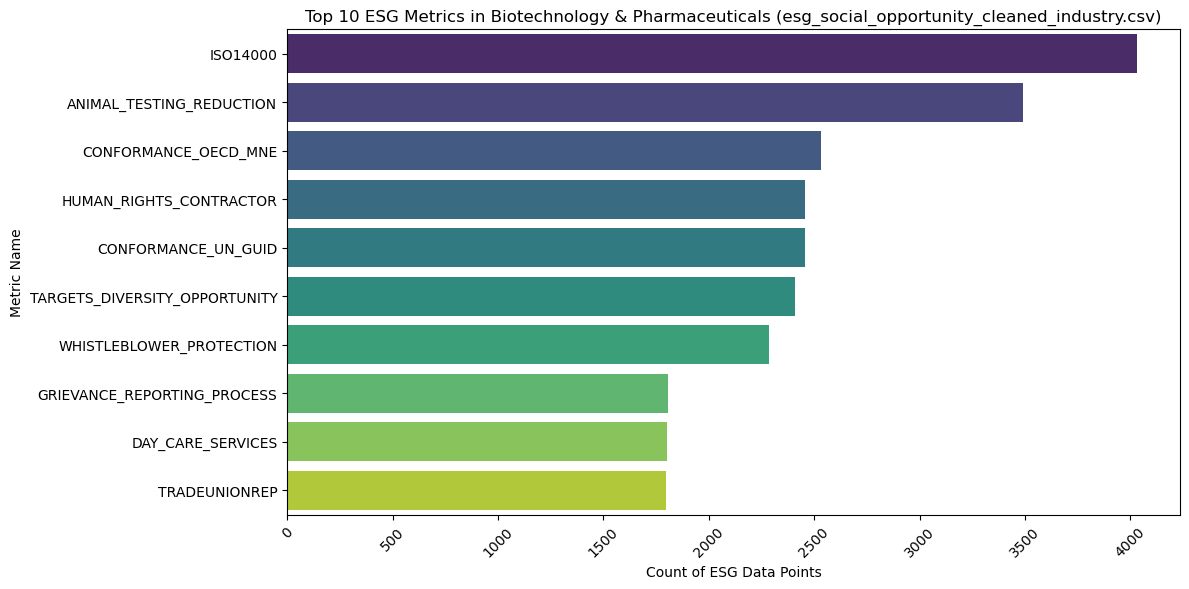

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


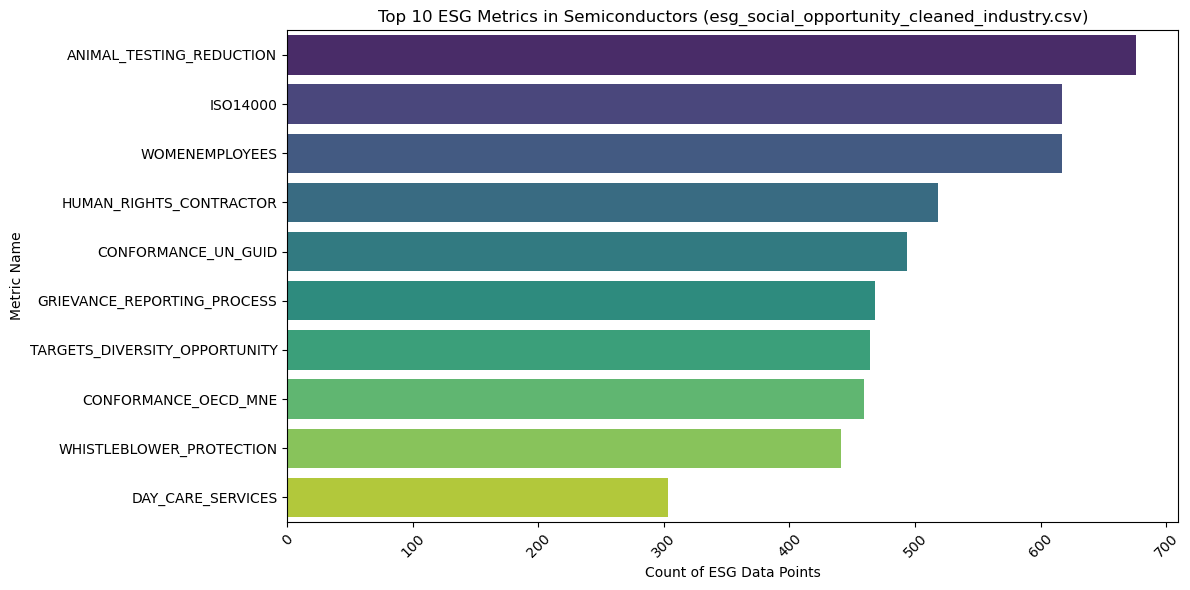

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


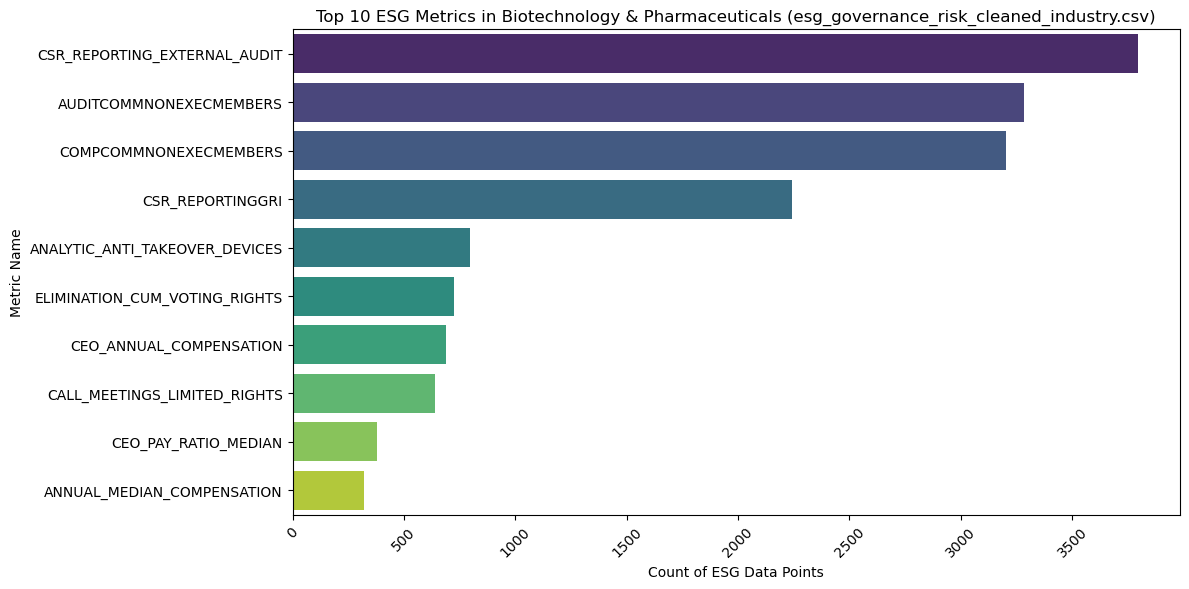

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


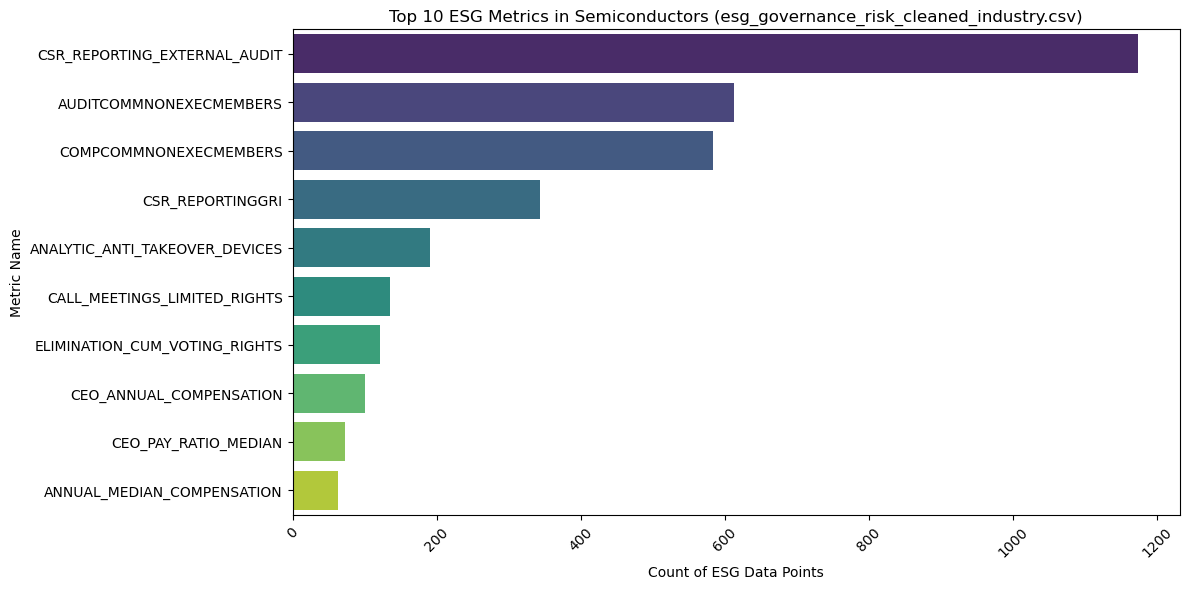

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


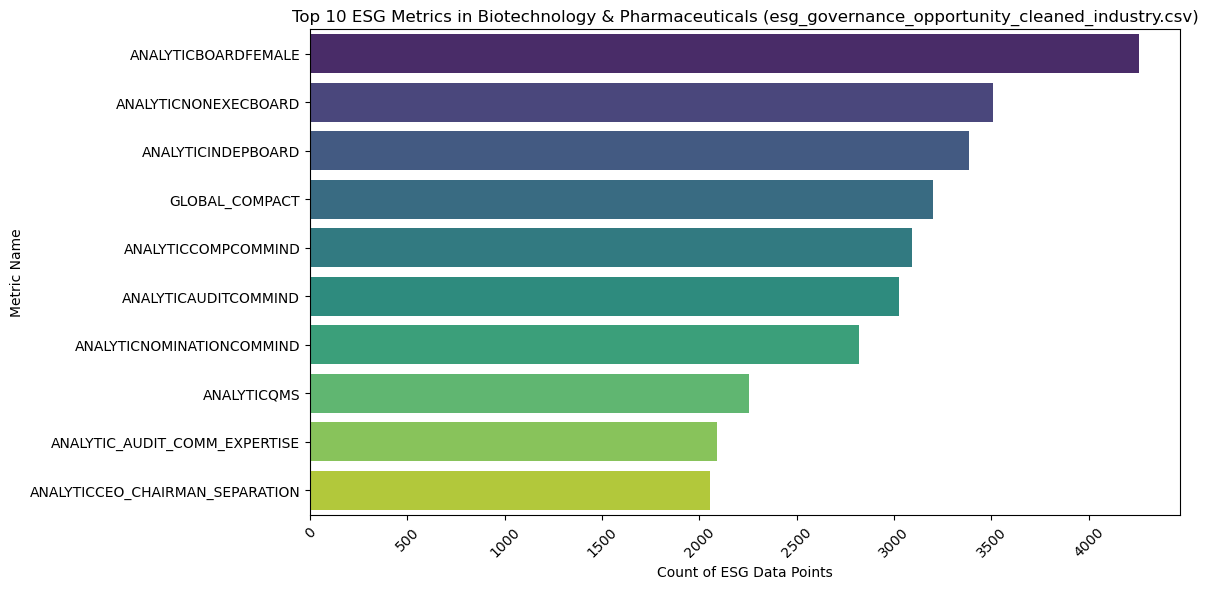

/var/folders/n8/sccqnmv56pn43hybjdjs0p_c0000gn/T/ipykernel_36259/2050915304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")


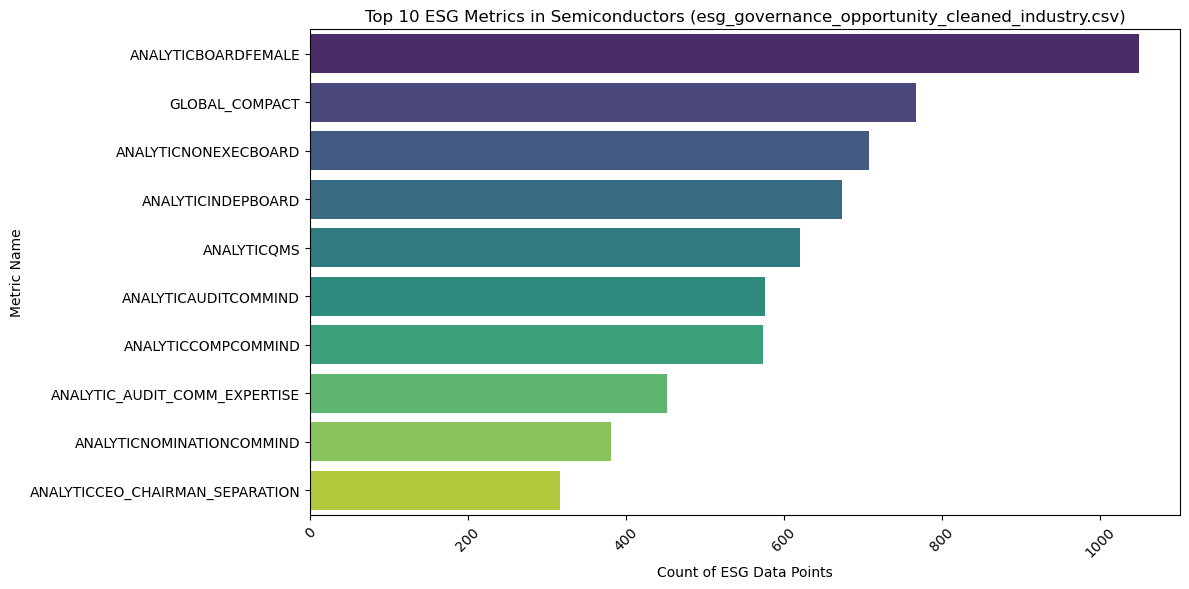

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to store Industry-wise analysis
industry_wise_analysis = {}

for filename, df in industry_data.items():
    if isinstance(df, pd.DataFrame):  # Ensure it's a DataFrame
        if "Industry" in df.columns and "metric_name" in df.columns:
            # Group by Industry, then count occurrences of each metric
            metric_counts = df.groupby("Industry")["metric_name"].value_counts().reset_index(name="count")

            # Store the results
            industry_wise_analysis[filename] = metric_counts

# Generate visualizations for each Industry dataset separately
for filename, df in industry_wise_analysis.items():
    unique_industries = df["Industry"].unique()

    for Industry in unique_industries:
        industry_df = df[df["Industry"] == Industry]

        if not industry_df.empty:
            plt.figure(figsize=(12, 6))
            
            # Select top 10 metrics per Industry
            top_metrics = industry_df.groupby("metric_name")["count"].sum().nlargest(10).reset_index()

            sns.barplot(data=top_metrics, x="count", y="metric_name", palette="viridis")
            plt.xlabel("Count of ESG Data Points")
            plt.ylabel("Metric Name")
            plt.title(f"Top 10 ESG Metrics in {Industry} ({filename})")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
